In [1]:
import os
import json
import re
import itertools
import math
from collections import defaultdict

import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.patches as patches
from matplotlib.colors import PowerNorm
from IPython.display import display, clear_output
from scipy.stats import t
from scipy.integrate import nquad

In [ ]:
# !pip install ipywidgets --upgrade
# !pip install jupyterlab_widgets
# !pip install --upgrade jupyterlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 1.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 2.4 MB/s eta 0:00:0000:010:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 1.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61/61 [jupyterlab]pyterlab]pyter-lsp]erver]gs]ions]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Truncated Regions Metrics

In [21]:
def load_all_metrics_flat(parent_directory):
    """Load and flatten all metrics from all result files"""
    all_metrics = []
    metrics_by_region = defaultdict(list)

    for root, _, files in os.walk(parent_directory):
        for filename in files:
            if filename.startswith("results_region") and filename.endswith(".json"):
                full_path = os.path.join(root, filename)
                try:
                    with open(full_path, 'r') as f:
                        content = json.load(f)
                except Exception as e:
                    print(f"⚠️ Failed to parse JSON at {full_path}: {e}")
                    continue

                region = content.get("parameters", {}).get("region")
                if region is None:
                    print(f"⚠️ No region found in: {full_path}")
                    continue

                metrics = content.get("metrics", {})
                flat_metrics = {
                    "SMD": metrics.get("SMD"),
                    "MAE": metrics.get("MAE"),
                    "MaxAE": metrics.get("MaxAE"),
                    "Intensity Min": metrics.get("intensity_stats", {}).get("min"),
                    "Intensity Mean": metrics.get("intensity_stats", {}).get("mean"),
                    "Intensity Max": metrics.get("intensity_stats", {}).get("max"),
                }

                all_metrics.append(flat_metrics)
                metrics_by_region[str(region)].append(flat_metrics)

    return all_metrics, metrics_by_region


def average_all_metrics(metric_entries):
    """Compute average over all collected metrics"""
    if not metric_entries:
        return {}

    metric_keys = metric_entries[0].keys()
    averages = {}
    for key in metric_keys:
        values = [entry[key] for entry in metric_entries if entry[key] is not None]
        averages[key] = sum(values) / len(values) if values else None
    return averages


def print_metrics_table(metrics_dict, title="Metrics"):
    df = pd.DataFrame(metrics_dict.items(), columns=["Metric", "Average"])
    df["Average"] = df["Average"].apply(lambda x: f"{x:.4f}" if x is not None else "N/A")
    print(f"\n📊 {title}:\n")
    print(df.to_string(index=False))

In [22]:
def list_run_results_dirs(path="."):
    return [f for f in os.listdir(path) 
            if os.path.isdir(os.path.join(path, f)) and f.startswith("run_results")]

def simplify_folder_name(folder_name):
    # Remove prefix 'run_results_statistical_analysis'
    name = folder_name.replace('run_results_statistical_analysis', '')
    # Remove everything after 'weight' (inclusive)
    if 'weight' in name:
        name = name.split('weight')[0]
    # Strip leading/trailing underscores or spaces
    return name.strip('_ ')

parent_path = "."  # adjust if needed

# Available directories
all_dirs = list_run_results_dirs(parent_path)

# Multi-select widget
dirs_select = widgets.SelectMultiple(
    options=all_dirs,
    description="Select folders:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='60%', height='200px')
)

# Track selection order
selection_order = []

def on_selection_change(change):
    global selection_order
    if change['name'] == 'value':
        new_selection = list(change['new'])
        # Keep order of already selected
        selection_order = [d for d in selection_order if d in new_selection]
        # Append newly selected at the end
        for d in new_selection:
            if d not in selection_order:
                selection_order.append(d)

dirs_select.observe(on_selection_change, names='value')

# Output widget
out = widgets.Output()
# Button to run computation
run_button = widgets.Button(description="Compute Metrics", button_style="success")

def on_run_button_clicked(b):
    with out:
        clear_output()
        try:
            selected_dirs = [os.path.join(parent_path, d) for d in selection_order]
            if not selected_dirs:
                print("⚠️ Please select at least one folder.")
                return
            
            all_plot_rows = []

            # Collect metrics for all selected directories
            for selected_dir in selected_dirs:
                print(f"Processing: {selected_dir}")
                all_metrics, metrics_by_region = load_all_metrics_flat(selected_dir)
                if not all_metrics:
                    print(f"⚠️ No valid metrics in {selected_dir}")
                    continue

                for region, region_metrics in metrics_by_region.items():
                    avg_region_metrics = average_all_metrics(region_metrics)
                    row = {k: avg_region_metrics[k] for k in ['SMD', 'MAE', 'MaxAE']}
                    row['Region'] = str(region)
                    row['Folder'] = os.path.basename(selected_dir)
                    all_plot_rows.append(row)

            if not all_plot_rows:
                print("⚠️ No data to plot.")
                return

            # Make one DataFrame with all directories combined
            full_df = pd.DataFrame(all_plot_rows)

            # Metrics to plot
            metrics_to_plot = ['SMD', 'MAE', 'MaxAE']
            colormaps = ['Reds', 'Greens', 'Blues']

            # Compute per-metric vmin/vmax across all selected dirs
            metric_ranges = {
                metric: (full_df[metric].min(), full_df[metric].max())
                for metric in metrics_to_plot
            }
            for metric, (mn, mx) in metric_ranges.items():
                print(f"{metric} range: {mn:.3f} → {mx:.3f}")

            # === New plotting layout ===
            num_regions = full_df['Region'].nunique()

            first_folder = os.path.basename(selected_dirs[0])
            region_orders_per_metric = {}
            for metric in metrics_to_plot:
                df_first = full_df[full_df['Folder'] == first_folder]
                df_first_sorted = df_first.sort_values(by=metric, ascending=True)
                region_orders_per_metric[metric] = df_first_sorted['Region'].tolist()
            
            # Scale figure height so regions are fully visible
            row_height = max(0.4 * num_regions, 3)  # min height = 3 inches per metric row
            fig, axes = plt.subplots(
                len(metrics_to_plot), len(selected_dirs),
                figsize=(len(selected_dirs)*3, row_height * len(metrics_to_plot)),
                sharey=False
            )
            
            # Ensure 2D axes array
            if len(metrics_to_plot) == 1:
                axes = [axes]  # one row
            if len(selected_dirs) == 1:
                axes = [[ax] for ax in axes]  # one col
            
            # === Plotting loop ===
            for row_idx, (metric, cmap) in enumerate(zip(metrics_to_plot, colormaps)):
                vmin, vmax = metric_ranges[metric]
                region_order = region_orders_per_metric[metric]  # use per-metric order
                for col_idx, folder in enumerate([os.path.basename(d) for d in selected_dirs]):
                    plot_df = full_df[full_df['Folder'] == folder].copy()
                    # enforce the metric-specific region order
                    plot_df['Region'] = pd.Categorical(plot_df['Region'], categories=region_order, ordered=True)
                    plot_df_sorted = plot_df.sort_values('Region')
                    metric_df = plot_df_sorted[['Region', metric]].set_index('Region')
                    
                    ax = axes[row_idx][col_idx]
                    sns.heatmap(
                        metric_df,
                        annot=True,
                        fmt=".3f",
                        cmap=cmap,
                        ax=ax,
                        norm=PowerNorm(gamma=0.3, vmin=vmin, vmax=vmax)
                    )
                    
                    # Titles and axis labels (same as before)
                    if row_idx == 0:
                        title = simplify_folder_name(folder)
                        ax.set_title(title, fontsize=10)
                    if col_idx == 0:
                        ax.set_ylabel(metric, fontsize=10)
                        ax.tick_params(axis='y', labelsize=8)
                        ax.set_yticklabels(region_order, rotation=0)
                    else:
                        ax.set_ylabel('')
                        ax.set_yticklabels([])
                    ax.set_xlabel('')
                    ax.tick_params(axis='x', labelsize=8, rotation=30)
            
            plt.tight_layout()
            output_dir = "plots/region_analysis"
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(os.path.join(output_dir, "metrics_heatmaps.png"), dpi=300, bbox_inches='tight')
            plt.show()

        except Exception as e:
            print("❌ Error:", e)

# Connect button to function
run_button.on_click(on_run_button_clicked)

# Display widgets
display(dirs_select, run_button, out)

SelectMultiple(description='Select folders:', layout=Layout(height='200px', width='60%'), options=('run_result…

Button(button_style='success', description='Compute Metrics', style=ButtonStyle())

Output()

## OLS Analysis

In [35]:
def extract_common_job_id(parent_directory):
    subdirs = [name for name in os.listdir(parent_directory)
               if os.path.isdir(os.path.join(parent_directory, name))]
    job_ids = []
    for d in subdirs:
        match = re.search(r"(job_\d+)", d)
        if match:
            job_ids.append(match.group(1))

    unique_job_ids = set(job_ids)
    if len(unique_job_ids) == 1:
        return unique_job_ids.pop()
    elif len(unique_job_ids) > 1:
        print(f"⚠️ Multiple job IDs found: {unique_job_ids}. Using the first one.")
        return list(unique_job_ids)[0]
    else:
        print("⚠️ No job ID found in subdirectory names. Using 'default'.")
        return "default"


def extract_region_str(region):
    """
    Convert region to readable string.
    Examples:
        [-1, 0.5] -> "[-1,0.5]"
        [[-1, 0.5], [-0.5, 1]] -> "[-1,0.5]x[-0.5,1]"
    """
    if isinstance(region[0], (int, float)):  # 1D region
        return f"[{region[0]},{region[1]}]"
    else:  # 2D or higher
        return "x".join(f"[{r[0]},{r[1]}]" for r in region)


def load_results_recursively(parent_directory):
    """Recursively search for all results_region*.json files and aggregate metrics by region"""
    from collections import defaultdict
    aggregated_metrics = defaultdict(list)

    for root, _, files in os.walk(parent_directory):
        for filename in files:
            if filename.startswith("results_region") and filename.endswith(".json"):
                full_path = os.path.join(root, filename)
                with open(full_path, 'r') as f:
                    try:
                        content = json.load(f)
                    except json.JSONDecodeError:
                        print(f"⚠️ Failed to parse JSON: {full_path}")
                        continue

                region = content.get("parameters", {}).get("region")
                if region is None:
                    print(f"⚠️ No region info found in: {full_path}")
                    continue

                region_str = extract_region_str(region)
                metrics = content.get("metrics", {})
                flat_metrics = {
                    "SMD": metrics.get("SMD"),
                    "MAE": metrics.get("MAE"),
                    "MaxAE": metrics.get("MaxAE"),
                    "Intensity Min": metrics.get("intensity_stats", {}).get("min"),
                    "Intensity Mean": metrics.get("intensity_stats", {}).get("mean"),
                    "Intensity Max": metrics.get("intensity_stats", {}).get("max"),
                }

                aggregated_metrics[region_str].append(flat_metrics)

    # Average the metrics per region
    averaged_metrics_by_region = {}
    for region, entries in aggregated_metrics.items():
        avg_metrics = {}
        keys = entries[0].keys()
        for key in keys:
            valid_values = [e[key] for e in entries if e[key] is not None]
            avg_metrics[key] = sum(valid_values) / len(valid_values) if valid_values else None
        averaged_metrics_by_region[region] = avg_metrics

    return aggregated_metrics


def plot_grouped_metrics(metrics_by_region, save_dir, sort_by="SMD"):
    primary_metrics = ["SMD", "MAE", "MaxAE"]
    intensity_metrics = ["Intensity Min", "Intensity Mean", "Intensity Max"]

    # Sort regions by the mean value of the `sort_by` metric
    filtered = []
    for region, entries in metrics_by_region.items():
        values = [entry.get(sort_by) for entry in entries if entry.get(sort_by) is not None]
        if values:
            mean_sort_by = sum(values) / len(values)
            filtered.append((region, entries, mean_sort_by))

    filtered.sort(key=lambda x: x[2])  # Sort by mean of sort_by

    region_labels = [region for region, _, _ in filtered]
    sorted_data = [entries for _, entries, _ in filtered]

    def make_dataframe(metric_list):
        rows = []
        for region, entries in zip(region_labels, sorted_data):
            for metric in metric_list:
                values = [entry[metric] for entry in entries if entry.get(metric) is not None]
                if not values:
                    continue
                mean = np.mean(values)
                sem = np.std(values, ddof=1) / np.sqrt(len(values))  # Standard error
                ci = t.ppf(0.975, df=len(values)-1) * sem if len(values) > 1 else 0  # 95% CI
                rows.append({
                    "Region": region,
                    "Metric": metric,
                    "Mean": mean,
                    "CI": ci
                })
        return pd.DataFrame(rows)

    def plot(df, filename_suffix):
        plt.figure(figsize=(6, 6))
        sns.set(style="whitegrid", font_scale=0.8)

        # Define shades of the same base color (e.g., blue)
        base_color = np.array(sns.color_palette("Blues", n_colors=4)[1:])
        shade_colors = base_color[:len(df["Metric"].unique())]  # pick shades

        # Create a palette mapping each metric to a different shade
        metric_names = df["Metric"].unique()
        custom_palette = {metric: tuple(shade_colors[i]) for i, metric in enumerate(metric_names)}

        ax = sns.pointplot(
            data=df,
            x="Region",
            y="Mean",
            hue="Metric",
            markers=".",
            errorbar=None,
            linestyle='none',
            dodge=True,
            palette=custom_palette  # use custom shades
        )

         # Add custom error bars manually
        for i, region in enumerate(df["Region"].unique()):
            for j, metric in enumerate(df["Metric"].unique()):
                subset = df[(df["Region"] == region) & (df["Metric"] == metric)]
                if not subset.empty:
                    # dodge_offset = 0.2 * (j - 1)  # Adjust dodge: assumes max 3 metrics
                    x = i # + dodge_offset
                    y = subset["Mean"].values[0]
                    ci = subset["CI"].values[0]
                    ax.errorbar(
                        x, y, yerr=ci,
                        fmt='none', color=custom_palette[metric],
                        capsize=2, linewidth=1
                    )
                
        # Add the numbers near the dots (make them small)
        for i, region in enumerate(df["Region"].unique()):
            for j, metric in enumerate(df["Metric"].unique()):
                subset = df[(df["Region"] == region) & (df["Metric"] == metric)]
                if not subset.empty:
                    x = i
                    y = subset["Mean"].values[0]
                    ax.text(
                        x + 0.3, y, f"{y:.2f}", color='black', fontsize=5,  # Smaller font size
                        ha='center', va='bottom', 
                    )
        ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

        ax.set_xlabel("Region", fontsize=10)
        ax.set_ylabel("Metric Value", fontsize=10)
        ax.set_title(f"Metrics by Region (sorted by {sort_by})", fontsize=11)
        ax.legend(loc="upper right", fontsize='small', frameon=True)

        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)

        plt.tight_layout(pad=1)
        filename = os.path.join(save_dir, f"region_plot_{filename_suffix}.png")
        plt.savefig(filename, dpi=300)
        print(f"✅ Saved plot: {filename}")
        plt.close()

    df_primary = make_dataframe(primary_metrics)
    df_intensity = make_dataframe(intensity_metrics)

    plot(df_primary, "primary")
    plot(df_intensity, "intensity")


def dynamic_feature_plots(metrics_by_region, target_metric="SMD", p_thresh=0.1, save_dir=None, vmin=None, vmax=None):
    data = []
    for region_str, entries in metrics_by_region.items():
        metrics = {
            metric: np.mean([e[metric] for e in entries if e[metric] is not None])
            for metric in ["SMD", "MAE", "MaxAE"]
        }
        features = extract_region_features(region_str)
        row = {**features, **metrics}
        row["region"] = region_str
        data.append(row)

    df = pd.DataFrame(data).dropna(subset=[target_metric])
    feature_cols = [c for c in df.columns if c not in ["region", "SMD", "MAE", "MaxAE"]]

    # Fit OLS model
    X = df[feature_cols]
    y = df[target_metric]
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    p_values = model.pvalues.drop("const", errors="ignore")

    # === Individual Feature Plots ===
    ncols = 2
    nrows = math.ceil(len(feature_cols) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axes = axes.flatten()

    for idx, feat in enumerate(feature_cols):
        ax = axes[idx]

        # Scatter of raw data
        sns.scatterplot(x=df[feat], y=df[target_metric], marker=".", ax=ax)

        # --- Partial regression line in original dimensions ---
        # Predict target using the full model
        y_hat = model.fittedvalues
        coef = model.params[feat]
        intercept = model.params["const"]

        # Compute adjusted line: vary only `feat`, hold others at their mean
        x_range = np.linspace(df[feat].min(), df[feat].max(), 100)
        other_means = df[feature_cols].mean()

        # Exclude the feature being plotted and const
        other_means_excl = other_means.drop(feat)
        other_params_excl = model.params.drop([feat, "const"], errors="ignore")

        y_line = (
            model.params["const"]
            + model.params[feat] * x_range
            + np.dot(other_means_excl, other_params_excl)
        )

        ax.plot(x_range, y_line, color="red", linewidth=1.5, label="Partial OLS fit")
        ax.legend(fontsize=7)

        # Annotate points
        for i in range(len(df)):
            ax.text(
                df[feat].iloc[i], df[target_metric].iloc[i], df["region"].iloc[i],
                fontsize=5,
                ha="center", va="bottom",
                bbox=dict(boxstyle="round,pad=0.2", edgecolor="none", facecolor="white", alpha=0.7)
            )

        # Title with OLS p-value
        pval = p_values.get(feat, np.nan)
        ax.set_title(f"{target_metric} vs {feat} (partial, p = {pval:.3g})", fontsize=10, pad=10)
        ax.set_xlabel(feat, fontsize=9)
        ax.set_ylabel(target_metric, fontsize=9)

        for label in ax.get_xticklabels():
            label.set_rotation(45)


    # Remove extra axes
    for j in range(len(feature_cols), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=2.0)

    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # If saving the plot, save it to the specified directory
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        path = os.path.join(save_dir, f"{target_metric}_feature_grid.png")
        fig.savefig(path, dpi=300)
        print(f"✅ Saved feature-vs-metric grid: {path}")
    else:
        plt.show()

    # === Residual Plot ===
    plot_residuals_vs_fitted(model, X_const, y, save_dir=save_dir)

    from sklearn.ensemble import GradientBoostingRegressor

    # === Significant Feature Pair Grids ===
    sig_feats = [feat for feat, pval in p_values.items() if feat != "const" and pval < p_thresh]

    if len(sig_feats) >= 2:
        combs = list(itertools.combinations(sig_feats, 2))
        ncols = 3
        nrows = math.ceil(len(combs) / ncols)

        fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
        axes = axes.flatten()

        for idx, (feat_x, feat_y) in enumerate(combs):
            ax = axes[idx]

            x = df[feat_x].values
            y = df[feat_y].values
            z = df[target_metric].values

            # --- Regression Surface ---
            X_model = np.column_stack([x, y])
            model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
            model.fit(X_model, z)

            # Predict at original data points
            z_pred = model.predict(np.column_stack([x, y]))

            # Power normalization
            norm = PowerNorm(gamma=0.5, vmin=vmin, vmax=vmax)

            # Contour on triangulated surface
            cs = ax.tricontourf(x, y, z_pred, levels=20, cmap="winter", alpha=0.9, norm=norm, vmin=vmin, vmax=vmax)

            # Scatter points
            ax.scatter(x, y, c=z, cmap="winter", edgecolor="white", marker='.',
                        linewidth=0.3, s=25, zorder=10, norm=norm)

            # Colorbar
            cbar = plt.colorbar(cs, ax=ax, orientation="vertical", pad=0.02)
            cbar.ax.tick_params(labelsize=8)
            cbar.set_label(target_metric, fontsize=9)

            buffer_x = (x.max() - x.min()) * 0.1
            buffer_y = (y.max() - y.min()) * 0.1
            ax.set_xlim(x.min() - buffer_x, x.max() + buffer_x)
            ax.set_ylim(y.min() - buffer_y, y.max() + buffer_y)

            # Region labels
            seen_coords = {}
            for i in range(len(df)):
                coord = (round(x[i], 3), round(y[i], 3))
                va = 'bottom' if seen_coords.get(coord, 0) == 0 else 'top'
                seen_coords[coord] = seen_coords.get(coord, 0) + 1

                ax.text(
                    x[i], y[i], df["region"].iloc[i],
                    fontsize=5, ha='center', va=va,
                    bbox=dict(boxstyle='round,pad=0.2', edgecolor='none', facecolor='white', alpha=0.7)
                )

            for spine in ax.spines.values():
                spine.set_visible(False)
            ax.set_xlabel(feat_x, fontsize=9)
            ax.set_ylabel(feat_y, fontsize=9)
            ax.set_title(f"{feat_y} vs {feat_x}\nRegression Surface of {target_metric}", fontsize=10)
            ax.grid(False)

        # Remove unused subplots
        for j in range(len(combs), len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout(pad=2.0)

        if save_dir:
            path = os.path.join(save_dir, f"{target_metric}_sig_feature_regression.png")
            fig.savefig(path, dpi=300, bbox_inches='tight')
            print(f"✅ Saved regression grid: {path}")
        else:
            plt.show()
    else:
        print("⚠️ Not enough significant features to plot regression surfaces.")

def extract_region_features(region, scale=0.5):
    """
    Computes the center of mass (mean) and variance per dimension of the
    isotropic Gaussian-like intensity within a given region.

    Parameters:
    - region: array-like shape (d, 2), e.g. [[xmin, xmax], [ymin, ymax], ...]
    - scale: float, the scale parameter of the Gaussian

    Returns:
    - dict with mu_i, sigma_i, mu_norm, sigma_trace, etc.
    """
    parts = region.split('x')
    dims = []

    try:
        for p in parts:
            bounds = re.findall(r"[-\d.]+", p)
            if len(bounds) != 2:
                raise ValueError(f"Expected two bounds per dimension, got: {bounds}")
            dim = list(map(float, bounds))
            dims.append(dim)
    except Exception as e:
        print(f"⚠️ Failed to parse region '{region}': {e}")
        return {}
    
    region = np.array(dims)
    d = region.shape[0]
    bounds = region[::-1].tolist()  # reverse for nquad

    def intensity(*coords):
        r2 = sum(x**2 for x in coords)
        return np.exp(-r2 / scale**2)

    # Normalization constant Z = ∫ λ(x) dx over region
    Z, _ = nquad(intensity, bounds)

    mus = []
    vars_ = []

    for i in range(d):
        def moment1(*coords):
            return coords[i] * intensity(*coords)

        def moment2(*coords):
            return coords[i]**2 * intensity(*coords)

        mu_i, _ = nquad(moment1, bounds)
        mu_i /= Z
        mus.append(mu_i)

        E_x2, _ = nquad(moment2, bounds)
        sigma2_i = E_x2 / Z - mu_i**2
        vars_.append(sigma2_i)

    mus = np.array(mus)
    sigmas = np.sqrt(np.array(vars_))

    features = {}
    # for i, (mu, sigma) in enumerate(zip(mus, sigmas)):
    #    features[f"mu_{i}"] = mu
    #    features[f"sigma_{i}"] = sigma

    features["mu_norm"] = np.linalg.norm(mus)
    features["sigma_det"] = np.prod(vars_)

    return features


def compute_and_plot_feature_effects(metrics_by_region, save_dir=None):
    # --- Step 1: Collect data
    data = []
    for region_str, entries in metrics_by_region.items():
        metrics = {
            metric: np.mean([e[metric] for e in entries if e[metric] is not None])
            for metric in ["SMD", "MAE", "MaxAE"]
        }
        features = extract_region_features(region_str)
        row = {**features, **metrics}
        row["region"] = region_str
        data.append(row)

    df = pd.DataFrame(data).dropna()

    metric_cols = ["SMD", "MAE", "MaxAE"]
    feature_cols = [col for col in df.columns if col not in metric_cols + ["region"]]

    # --- Step 2: Plot heatmap (optional, keep from your original code)
    corr = df[metric_cols + feature_cols].corr()
    corr_subset = corr.loc[metric_cols, feature_cols]
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_subset, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
    plt.title("Correlation between Region Features and Performance Metrics")
    plt.xlabel("Region Features")
    plt.ylabel("Performance Metrics")
    plt.tight_layout()
    if save_dir:
        heatmap_path = os.path.join(save_dir, "region_feature_correlations.png")
        plt.savefig(heatmap_path, dpi=300)
        print(f"✅ Saved correlation heatmap: {heatmap_path}")
    else:
        plt.show()
    plt.close()

    # --- Step 3: Fit regression models and print results
    for metric in metric_cols:
        print(f"\n📊 Linear Regression for {metric}")
        X = df[feature_cols]
        X = sm.add_constant(X)
        y = df[metric]
        

        model = sm.OLS(y, X).fit()
        print(model.summary())

        # Optional: Save regression summary to file
        if save_dir:
            summary_path = os.path.join(save_dir, f"regression_{metric}.txt")
            with open(summary_path, "w") as f:
                f.write(model.summary().as_text())
            print(f"✅ Saved regression summary: {summary_path}")


def plot_residuals_vs_fitted(model, X, y, title="Residuals vs. Fitted", save_dir=None):
    """
    Plot residuals vs. fitted (predicted) values for an OLS model.
    """
    fitted_vals = model.predict(X)
    residuals = y - fitted_vals

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=fitted_vals, y=residuals, edgecolor="k")
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.tight_layout()
    if save_dir:
        path = os.path.join(save_dir, "residuals_plot.png")
        plt.savefig(path, dpi=300)
        print(f"✅ Saved residuals plot: {path}")
    


SelectMultiple(description='Parent Dirs:', layout=Layout(height='150px', width='100%'), options=('run_results_…

Button(description='Load Results', layout=Layout(width='100%'), style=ButtonStyle())

Output(layout=Layout(width='100%'))

Dropdown(description='Sort by:', layout=Layout(width='100%'), options=('SMD', 'MAE', 'MaxAE'), value='SMD')

Button(description='Plot Grouped Metrics', layout=Layout(width='100%'), style=ButtonStyle())

Output(layout=Layout(width='100%'))

Dropdown(description='Target Metric:', layout=Layout(width='100%'), options=('SMD', 'MAE', 'MaxAE'), value='SM…

FloatSlider(value=0.1, description='p-thresh:', layout=Layout(width='100%'), max=0.5, min=0.01, step=0.01)

Button(description='Dynamic Feature Plots', layout=Layout(width='100%'), style=ButtonStyle())

Output(layout=Layout(width='100%'))

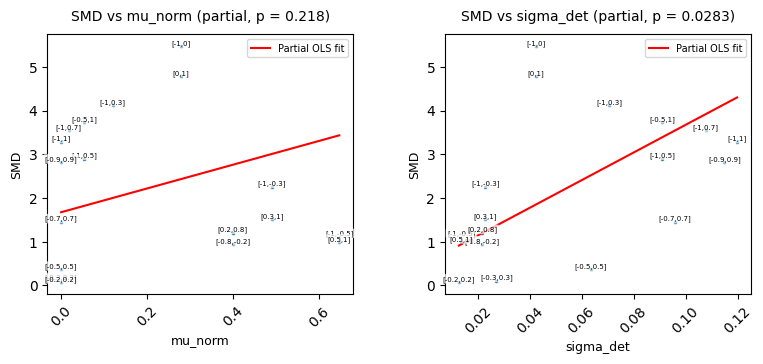

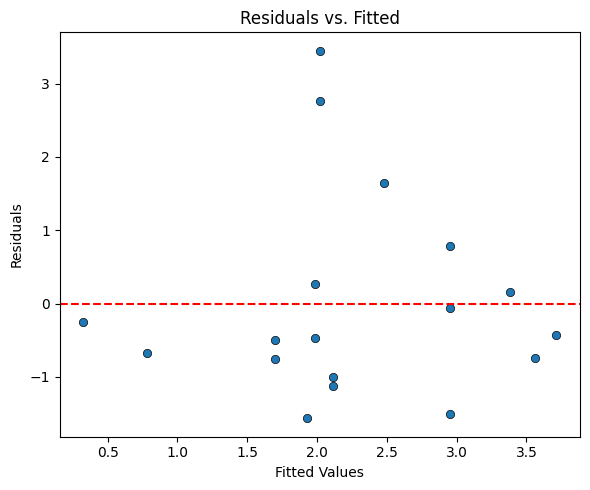

In [36]:
def get_run_results_dirs(base_path="."):
    return sorted([
        f for f in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, f)) and f.startswith("run_results")
    ])

# Dropdown for parent_dir
parent_dirs_widget = widgets.SelectMultiple(
    options=get_run_results_dirs("."),
    description='Parent Dirs:',
    layout=widgets.Layout(width='100%', height='150px')
)


load_button = widgets.Button(description='Load Results', layout=widgets.Layout(width='100%'))
output_load = widgets.Output(layout=widgets.Layout(width='100%'))

metrics_data = {}

# Load button callback
def load_results_callback(b):
    with output_load:
        output_load.clear_output()
        global metrics_data
        metrics_data = {}
        selected_dirs = parent_dirs_widget.value
        if not selected_dirs:
            print("⚠️ No directories selected.")
            return
        print(f"Loading results from {len(selected_dirs)} directories...")
        from collections import defaultdict
        merged = defaultdict(list)
        for d in selected_dirs:
            sub_metrics = load_results_recursively(d)
            for region, entries in sub_metrics.items():
                merged[region].extend(entries)
        metrics_data = dict(merged)
        print(f"✅ Loaded results for {len(metrics_data)} regions across {len(selected_dirs)} dirs")

load_button.on_click(load_results_callback)

display(parent_dirs_widget, load_button, output_load)

# Widgets for plotting
metric_sort_widget = widgets.Dropdown(
    options=['SMD', 'MAE', 'MaxAE'],
    value='SMD',
    description='Sort by:',
    layout=widgets.Layout(width='100%')
)
plot_button = widgets.Button(description='Plot Grouped Metrics', layout=widgets.Layout(width='100%'))
output_plot = widgets.Output(layout=widgets.Layout(width='100%'))

def plot_metrics_callback(b):
    with output_plot:
        output_plot.clear_output()
        selected_dirs = parent_dirs_widget.value
        if not selected_dirs:
            print("⚠️ No directories selected.")
            return

        sort_by = metric_sort_widget.value
        print(f"Plotting grouped metrics sorted by {sort_by} for {len(selected_dirs)} runs...")

        for d in selected_dirs:
            sub_metrics = load_results_recursively(d)
            if not sub_metrics:
                print(f"⚠️ No metrics data found in {d}")
                continue

            save_dir = d  # save directly inside the run_results folder
            os.makedirs(save_dir, exist_ok=True)

            print(f"📂 Processing {d}...")
            plot_grouped_metrics(sub_metrics, save_dir, sort_by=sort_by)

        print("\n✅ Done plotting for all selected runs")

plot_button.on_click(plot_metrics_callback)

display(metric_sort_widget, plot_button, output_plot)

# Widget for dynamic feature plots
target_metric_widget = widgets.Dropdown(
    options=['SMD', 'MAE', 'MaxAE'],
    value='SMD',
    description='Target Metric:',
    layout=widgets.Layout(width='100%')
)
p_thresh_widget = widgets.FloatSlider(
    value=0.1,
    min=0.01,
    max=0.5,
    step=0.01,
    description='p-thresh:',
    layout=widgets.Layout(width='100%')
)
dynamic_plot_button = widgets.Button(description='Dynamic Feature Plots', layout=widgets.Layout(width='100%'))
output_dynamic = widgets.Output(layout=widgets.Layout(width='100%'))

# Dynamic feature plot callback
def dynamic_plot_callback(b):
    with output_dynamic:
        output_dynamic.clear_output()
        selected_dirs = parent_dirs_widget.value
        if not selected_dirs:
            print("⚠️ No directories selected.")
            return

        target_metric = target_metric_widget.value
        p_thresh = p_thresh_widget.value

        # Step 1 — Collect all metric values for global scaling
        all_values = []
        all_data_per_dir = {}
        for d in selected_dirs:
            sub_metrics = load_results_recursively(d)
            all_data_per_dir[d] = sub_metrics
            for region_str, entries in sub_metrics.items():
                vals = [e[target_metric] for e in entries if e[target_metric] is not None]
                if vals:
                    all_values.append(np.mean(vals))

        if not all_values:
            print("⚠️ No values found for metric:", target_metric)
            return
        
        global_vmin = np.min(all_values)
        global_vmax = np.max(all_values)

        # Step 2 — Plot each run separately with same vmin/vmax
        for d in selected_dirs:
            print(f"\n📂 Processing {d}...")
            save_dir = d
            os.makedirs(save_dir, exist_ok=True)
            try:
                dynamic_feature_plots(
                    all_data_per_dir[d],
                    target_metric=target_metric,
                    p_thresh=p_thresh,
                    save_dir=save_dir,
                    vmin=global_vmin,
                    vmax=global_vmax,
                )
            except Exception as e:
                import traceback
                print(f"⚠️ Error in {d}: {e}")
                traceback.print_exc()
        print("\n✅ Done dynamic plots for all selected runs")

dynamic_plot_button.on_click(dynamic_plot_callback)

display(target_metric_widget, p_thresh_widget, dynamic_plot_button, output_dynamic)

## L Analysis

In [2]:
def extract_region_str(region):
    """Convert region to readable string."""
    if isinstance(region[0], (int, float)):
        return f"[{region[0]},{region[1]}]"
    else:
        return "x".join(f"[{r[0]},{r[1]}]" for r in region)

def load_results_recursively(parent_directory):
    """Recursively load JSON results and aggregate metrics by region."""
    aggregated_metrics = defaultdict(list)
    for root, _, files in os.walk(parent_directory):
        for filename in files:
            if filename.startswith("results_region") and filename.endswith(".json"):
                full_path = os.path.join(root, filename)
                with open(full_path, 'r') as f:
                    try:
                        content = json.load(f)
                    except json.JSONDecodeError:
                        print(f"⚠️ Failed to parse JSON: {full_path}")
                        continue

                region = content.get("parameters", {}).get("region")
                if region is None:
                    print(f"⚠️ No region info found in: {full_path}")
                    continue

                region_str = extract_region_str(region)
                metrics = content.get("metrics", {})
                flat_metrics = {
                    "SMD": metrics.get("SMD"),
                    "MAE": metrics.get("MAE"),
                    "MaxAE": metrics.get("MaxAE"),
                    "Intensity Min": metrics.get("intensity_stats", {}).get("min"),
                    "Intensity Mean": metrics.get("intensity_stats", {}).get("mean"),
                    "Intensity Max": metrics.get("intensity_stats", {}).get("max"),
                }
                aggregated_metrics[region_str].append(flat_metrics)

    averaged_metrics_by_region = {}
    for region, entries in aggregated_metrics.items():
        avg_metrics = {}
        keys = entries[0].keys()
        for key in keys:
            valid_values = [e[key] for e in entries if e[key] is not None]
            avg_metrics[key] = sum(valid_values) / len(valid_values) if valid_values else None
        averaged_metrics_by_region[region] = avg_metrics

    return averaged_metrics_by_region

In [16]:
BASE_DIR = os.getcwd()
percent_pattern = re.compile(r"run_results_statistical_analysis_capped_distance_weight_1D_percent_(\d+(?:\.\d+)?)")

records = []
for folder in os.listdir(BASE_DIR):
    match = percent_pattern.match(folder)
    if not match:
        continue

    percent = float(match.group(1))
    folder_path = os.path.join(BASE_DIR, folder)
    averaged_by_region = load_results_recursively(folder_path)

    for region_str, metrics in averaged_by_region.items():
        for metric_name, value in metrics.items():
            if value is not None:
                records.append({
                    "percent": percent,
                    "region": region_str,
                    "metric": metric_name,
                    "value": value
                })

df = pd.DataFrame(records)
df.head()

plot_dir = os.path.join(BASE_DIR, "plots")
os.makedirs(plot_dir, exist_ok=True)

for metric in df["metric"].unique():
    plt.figure(figsize=(12, 8))
    subset = df[df["metric"] == metric].copy()

    # Average per percent
    avg_metric = (
        subset.groupby("percent")["value"]
        .mean()
        .reset_index()
        .sort_values(by="value", ascending=True)
    )

    avg_metric["percent_str"] = avg_metric["percent"].astype(str)
    sorted_percent_str = avg_metric["percent_str"].tolist()
    subset["percent_str"] = subset["percent"].astype(str)

    plt.plot(avg_metric["percent_str"], avg_metric["value"], color="black",
             label="Average", linewidth=2, linestyle="--")

    for x, y in zip(avg_metric["percent_str"], avg_metric["value"]):
        plt.text(x, y, f"{y:.4f}", ha='center', va='bottom', fontsize=8, color='black')

    for region in subset["region"].unique():
        region_subset = subset[subset["region"] == region].copy()
        region_avg = region_subset.groupby("percent_str")["value"].mean().reindex(sorted_percent_str)
        plt.plot(sorted_percent_str, region_avg, alpha=0.5, label=region)

    plt.title(f"{metric} vs Percent (sorted by average value)")
    plt.xlabel("Percent")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    plt.tight_layout()

    # Save file
    safe_metric = metric.replace(" ", "_").replace(".", "").lower()
    filename = f"{safe_metric}_vs_percent_by_region_with_avg.png"
    filepath = os.path.join(plot_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()
    print(f"✅ Saved: {filepath}")

✅ Saved: /home/h5/anku138f/score_matching/plots/smd_vs_percent_by_region_with_avg.png
✅ Saved: /home/h5/anku138f/score_matching/plots/mae_vs_percent_by_region_with_avg.png
✅ Saved: /home/h5/anku138f/score_matching/plots/maxae_vs_percent_by_region_with_avg.png
✅ Saved: /home/h5/anku138f/score_matching/plots/intensity_min_vs_percent_by_region_with_avg.png
✅ Saved: /home/h5/anku138f/score_matching/plots/intensity_mean_vs_percent_by_region_with_avg.png
✅ Saved: /home/h5/anku138f/score_matching/plots/intensity_max_vs_percent_by_region_with_avg.png


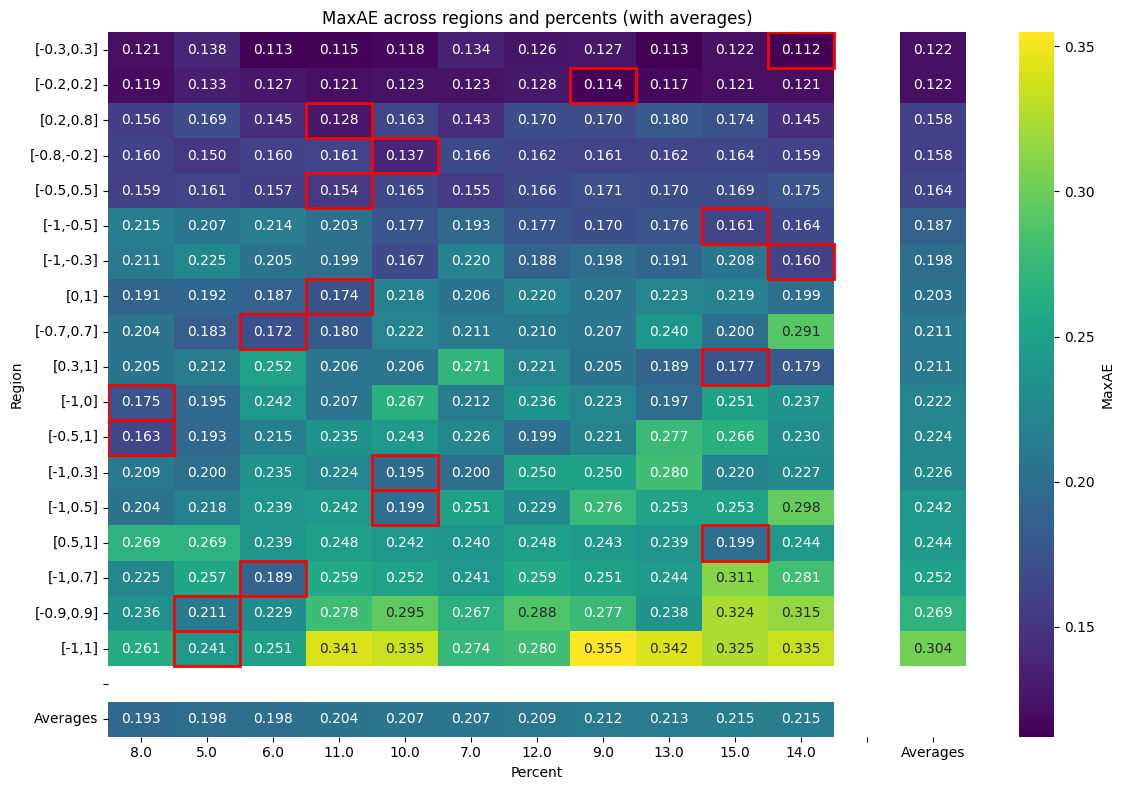

In [20]:
metric_to_plot = "MaxAE"  # change to your metric

# Filter the DataFrame
df_metric = df[df["metric"] == metric_to_plot]

# Pivot: rows=region, columns=percent
heatmap_data = df_metric.pivot(index="region", columns="percent", values="value")

# Sort rows by row average
row_avg = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.loc[row_avg.sort_values(ascending=True).index]

# Sort cols by col average
col_avg = heatmap_data.mean(axis=0)
heatmap_data = heatmap_data[col_avg.sort_values(ascending=True).index]

# --- Add whitespace + averages row/col ---
# Insert blank row (all NaN)
heatmap_data.loc[""] = np.nan  

# Add averages row below
heatmap_data.loc["Averages", :] = np.nan
heatmap_data.loc["Averages", heatmap_data.columns] = col_avg

# Insert blank col (all NaN)
heatmap_data[""] = np.nan  

# Add averages column at far right
heatmap_data["Averages"] = np.nan
heatmap_data.loc[heatmap_data.index[:-2], "Averages"] = row_avg  # only original rows
heatmap_data.loc["Averages", "Averages"] = np.nan  # leave bottom-right empty

# Reorder so blank col is before "Averages"
cols = list(heatmap_data.columns)
cols.remove("")
cols.remove("Averages")
heatmap_data = heatmap_data[cols + ["", "Averages"]]

# Find the column with the lowest average (ignore blanks/averages)
min_col = col_avg.idxmin()
min_col_idx = list(heatmap_data.columns).index(min_col)

# Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    heatmap_data, annot=True, fmt=".3f", cmap="viridis", 
    cbar_kws={"label": metric_to_plot}
)

# Highlight lowest value per row (ignore blank + averages cols/rows)
for i, row in enumerate(heatmap_data.iloc[:-2].values):  # skip last 2 rows
    min_j = np.nanargmin(row[:-2])  # skip last 2 cols
    rect = patches.Rectangle((min_j, i), 1, 1, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.title(f"{metric_to_plot} across regions and percents (with averages)")
plt.xlabel("Percent")
plt.ylabel("Region")
plt.tight_layout()
plt.savefig(f"{metric_to_plot}_L_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()